In [1]:
import multiprocessing as mp
import time
from typing import Any, Generator, Literal

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.datasets import ImageFolder

%matplotlib inline

In [2]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

batch_size = 256

train_transform = tt.Compose(
    [
        tt.RandomCrop(32, padding=4, padding_mode="reflect"),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(mean, std, inplace=False),
    ]
)

test_transform = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

train_ds = ImageFolder("./data/cifar10/train", train_transform)
test_ds = ImageFolder("./data/cifar10/test", test_transform)

train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=mp.cpu_count() - 2, pin_memory=True
)

test_dl = DataLoader(
    test_ds, batch_size, num_workers=mp.cpu_count() - 2, pin_memory=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


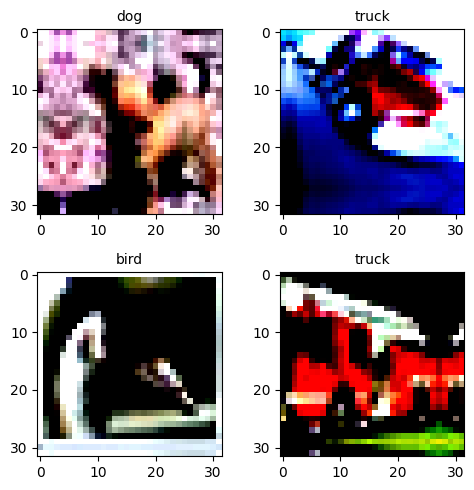

In [3]:
def img_is_color(img):
    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False


def show_image_list(
    list_images,
    list_titles=None,
    list_cmaps=None,
    grid=True,
    num_cols=2,
    figsize=(20, 10),
    title_fontsize=30,
):
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), "%d imgs != %d titles" % (
            len(list_images),
            len(list_titles),
        )

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), "%d imgs != %d cmaps" % (
            len(list_images),
            len(list_cmaps),
        )

    num_images = len(list_images)
    num_cols = min(num_images, num_cols)
    num_rows = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img = list_images[i]
        title = list_titles[i] if list_titles is not None else "Image %d" % (i)
        cmap = (
            list_cmaps[i]
            if list_cmaps is not None
            else (None if img_is_color(img) else "gray")
        )

        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()


list_images = []
list_labels = []

class_names = {idx: cls for cls, idx in train_dl.dataset.class_to_idx.items()}


for images, labels in train_dl:
    list_images.append(images[0].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[1].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[2].permute(1, 2, 0).cpu().detach().numpy())
    list_images.append(images[3].permute(1, 2, 0).cpu().detach().numpy())

    list_labels.append(class_names[int(labels[0].cpu().detach().numpy())])
    list_labels.append(class_names[int(labels[1].cpu().detach().numpy())])
    list_labels.append(class_names[int(labels[2].cpu().detach().numpy())])
    list_labels.append(class_names[int(labels[3].cpu().detach().numpy())])
    break

show_image_list(
    list_images, list_titles=list_labels, grid=False, figsize=(5, 5), title_fontsize=10
)

In [3]:
class Trainer(object):
    def __init__(
        self,
        model: nn.Module,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        optimizer: Any,
        loss: Any,
        device: Literal["cuda", "cpu"],
    ) -> None:
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.loss = loss
        self.device = device

    def _train_loop(self) -> float:
        self.model.train()

        corrects_quantity = 0

        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()

            images = images.type(torch.float32)
            images = images.to(self.device)
            labels = labels.to(self.device)

            preds = self.model(images)

            loss = self.loss(
                preds.type(torch.float32),
                F.one_hot(labels, num_classes=10).type(torch.float32),
            )

            corrects = labels == preds.argmax(dim=1)
            corrects_quantity += int(corrects.sum())

            loss.backward()
            self.optimizer.step()

        return corrects_quantity / 50_000

    def _test_loop(self) -> float:
        self.model.eval()
        corrects_quantity = 0

        with torch.no_grad():
            for images, labels in self.test_dataloader:
                self.optimizer.zero_grad()

                images = images.type(torch.float32)

                images = images.to(self.device)
                labels = labels.to(self.device)

                preds = self.model(images)

                corrects = labels == preds.argmax(dim=1)
                corrects_quantity += int(corrects.sum())

        return corrects_quantity / 10_000

    def train(self, epoch_num: int) -> Generator[nn.Module, None, None]:
        for epoch_no in range(epoch_num):
            start_time = time.time()
            train_accuracy = self._train_loop()
            time_of_train = time.time() - start_time

            start_time = time.time()
            test_accuracy = self._test_loop()
            time_of_test = time.time() - start_time

            print(f"Epoch: {epoch_no + 1}")
            print(f"Train accuracy: {train_accuracy:.4f}, time: {time_of_train:.2f}")
            print(f"Test accuracy: {test_accuracy:.4f}, time: {time_of_test:.2f}")

            yield self.model

In [4]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )

        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )

        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes,
            planes,
            kernel_size=1,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes,
            self.expansion * planes,
            kernel_size=1,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        num_blocks,
        num_classes=10,
    ):
        super().__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(
            3,
            64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


print(summary(ResNet18(), input_size=(256, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [256, 64, 32, 32]         128
├─Sequential: 1-3                        [256, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [256, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [256, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [256, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [256, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [256, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [256, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [256, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [256, 64, 32, 32]         

c:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\torchinfo\torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\Anton\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


In [5]:
def train(
    model, device, train_dataloader, test_dataloader, optimizer, loss, epochs_num
) -> None:
    model = model
    model = model.to(device)

    trainer = Trainer(
        model,
        train_dataloader,
        test_dataloader,
        optimizer,
        loss,
        device,
    )

    for model in trainer.train(epochs_num):
        print()

    return model

In [6]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
NETWORK = ResNet18()
OPTIMIZER = torch.optim.Adam(
    NETWORK.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

DEVICE = "cuda"
BATCH_SIZE = 256

LOSS = torch.nn.CrossEntropyLoss()
EPOCHS = 25


start_time = time.time()
trained_model = train(NETWORK, DEVICE, train_dl, test_dl, OPTIMIZER, LOSS, EPOCHS)

print()
print(f"Total time: {time.time() - start_time:.2f}")

Epoch: 1
Train accuracy: 0.4657, time: 48.10
Test accuracy: 0.5274, time: 29.27

Epoch: 2
Train accuracy: 0.6581, time: 49.03
Test accuracy: 0.6177, time: 30.25

Epoch: 3
Train accuracy: 0.7287, time: 49.10
Test accuracy: 0.7239, time: 30.02

Epoch: 4
Train accuracy: 0.7785, time: 47.72
Test accuracy: 0.7375, time: 29.05

Epoch: 5
Train accuracy: 0.8091, time: 48.08
Test accuracy: 0.8050, time: 29.11

Epoch: 6
Train accuracy: 0.8322, time: 47.30
Test accuracy: 0.8095, time: 29.69

Epoch: 7
Train accuracy: 0.8493, time: 48.35
Test accuracy: 0.8083, time: 29.41

Epoch: 8
Train accuracy: 0.8649, time: 47.48
Test accuracy: 0.8128, time: 29.52

Epoch: 9
Train accuracy: 0.8758, time: 48.17
Test accuracy: 0.7687, time: 29.22

Epoch: 10
Train accuracy: 0.8850, time: 48.60
Test accuracy: 0.8633, time: 29.14

Epoch: 11
Train accuracy: 0.8905, time: 48.07
Test accuracy: 0.8634, time: 29.49

Epoch: 12
Train accuracy: 0.8985, time: 47.62
Test accuracy: 0.8610, time: 29.16

Epoch: 13
Train accuracy: